# Predicting House Prices with Apache Spark

## LINEAR REGRESSION
ในส่วนนี้เราจะใช้ชุดข้อมูลที่เรียกว่า [California Housing](http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) โปรดทราบว่านั่นคือ 'ข้อมูลขนาดเล็ก' และการใช้ Spark ในบริบทนี้อาจจะเป็นการใช้งานที่เกินความจำเป็น (เหมาะกับ Big Data)  
สมุดบันทึกนี้เป็นเพียงเพื่อการศึกษาเท่านั้นและมีเจตนาที่จะให้เรารู้ว่าเราสามารถใช้ PySpark เพื่อสร้างโมเดลเรียนรู้ของเครื่องได้อย่างไร

<a id="10"></a> 
# Table of Contents  
**[1. Understanding the Data Set](#1)       
[2. Creating the Spark Session](#2)   
[3. Load The Data From a File Into a Dataframe](#3)   
[4. Data Exploration](#4)       
[5. Data Preprocessing](#5)       
[6. Feature Engineering](#6)  
[7. Building A Machine Learning Model With Spark ML](#7)  
[8. Evaluating the Model](#8)  
[9. Reference](#9)**

***

<a id="1"></a>
## 1. Understanding the Data Set
ชุดข้อมูล California Housing ปรากฏในบทความเมื่อปี 1997 ที่ชื่อ Sparse Spatial Autoregressions ที่เขียนโดย Pace, R. Kelley และ Ronald Barry และเผยแพร่ในวารสาร Statistics and Probability Letters นักวิจัยสร้างชุดข้อมูลนี้โดยใช้ข้อมูลสำรวจประชากรในรัฐแคลิฟอร์เนียปี 1990

ข้อมูลประกอบด้วยแถวละหนึ่งแถวต่อกลุ่มบล็อก กลุ่มบล็อก คือ หน่วยภูมิศาสตร์ที่เล็กที่สุดที่สำนักงานการสำรวจประชากรสหรัฐฯ จะเผยแพร่ข้อมูลตัวอย่าง (กลุ่มบล็อกมักมีประชากรประมาณ 600 ถึง 3,000 คน) ในตัวอย่างนี้ กลุ่มบล็อกในเฉลี่ยประกอบด้วยบุคคลจำนวนเฉลี่ย 1425.5 คนที่อาศัยอยู่ในพื้นที่ที่มีขนาดเล็กทางภูมิศาสตร์

ข้อมูลเชิงพื้นที่เหล่านี้ประกอบด้วยการสำรวจราคาที่บ้าน 20,640 ค่าสังเกตการณ์ พร้อมกับตัวแปรทางเศรษฐกิจ 9 ตัวแปร

**`Longitude:`** หมายถึงระยะทางมุมของสถานที่ทางภูมิศาสตร์ทางเหนือหรือทางใต้ของเส้นศูนย์ส่วนของโลกสำหรับแต่ละกลุ่มบล็อก  
**`Latitude:`** หมายถึงระยะทางมุมของสถานที่ทางภูมิศาสตร์ทางตะวันออกหรือทางตะวันตกของเส้นศูนย์ส่วนของโลกสำหรับแต่ละกลุ่มบล็อก  
**`Housing Median Age:`** เป็นอายุเฉลี่ยของคนที่อยู่ในกลุ่มบล็อก โปรดทราบว่าอายุเฉลี่ยหมายถึงค่าที่อยู่ตรงกลางของการกระจายความถี่ของค่าที่สังเกตเห็น  
**`Total Rooms:`** เป็นจำนวนห้องทั้งหมดในบ้านต่อกลุ่มบล็อก  
**`Total Bedrooms:`** เป็นจำนวนห้องนอนทั้งหมดในบ้านต่อกลุ่มบล็อก  
**`Population:`** เป็นจำนวนประชากรในกลุ่มบล็อก  
**`Households:`** เป็นหน่วยบ้านและผู้อาศัยต่อกลุ่มบล็อก  
**`Median Income:`** เป็นการลงทะเบียนรายได้เฉลี่ยของคนที่อยู่ในกลุ่มบล็อก  
**`Median House Value:`** เป็นตัวแปรตามซึ่งเป็นค่ากลางของมูลค่าบ้านเฉลี่ยต่อกลุ่มบล็อก  


นอกจากนี้เรายังได้เรียนรู้ว่าข้อมูลของตัวแปรอิสระ และตัวแปรตามทั้งหมดในกลุ่มบล็อกที่มีค่าเป็นศูนย์ถูกยกเว้นออกจากข้อมูล  

**`Median House Value`** เป็นตัวแปรตามที่เป็นตัวแปรขึ้นกับตัวแปรอิสระ และจะได้รับการกำหนดบทบาทเป็นตัวแปรเป้าหมายในโมเดลเรียนรู้ของเรา

### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np

# entry point
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

# Machine Learning & Evaluation
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context = 'notebook', 
        style = 'whitegrid', 
        rc = {'figure.figsize': (18, 4)})
rcParams['figure.figsize'] = 18, 4


In [3]:
# setting random seed for notebook reproducability
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

**[Back to Table of Contents](#10)**

***

<a id="2"></a>
## 2. Creating the Spark Session

จุดเริ่มต้นของการใช้ Spark คือ เราต้องสร้าง entry point หรือ ประตูที่สามารถให้เราเข้าไปใช้ฟังชั่นต่างๆใน Spark Core ได้ โดยเริ่มจากการอิมพอร์ท SparkContext

In [4]:
spark = SparkSession.builder.master('local[2]').appName('Linear-Regression-California-Housing').getOrCreate()
spark

In [5]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

In [6]:
sqlContext = SQLContext(sc)
sqlContext

C:\Users\PP\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


**[Back to Table of Contents](#10)**

***

<a id="3"></a>
## 3. Load The Data From a File Into a Dataframe

In [7]:
HOUSING_DATA = 'data/cal_housing.data'

In [8]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType(
                    [
                        StructField('long', FloatType(), nullable = True),
                        StructField('lat', FloatType(), nullable = True),
                        StructField('medage', FloatType(), nullable = True),
                        StructField('totrooms', FloatType(), nullable = True),
                        StructField('totbdrms', FloatType(), nullable = True),
                        StructField('pop', FloatType(), nullable = True),
                        StructField('houshlds', FloatType(), nullable = True),
                        StructField('medinc', FloatType(), nullable = True),
                        StructField('medhv', FloatType(), nullable = True)
                    ]
)

In [9]:
# Load housing data
import time
start_time = time.time()

housing_df = spark.read.csv(path = HOUSING_DATA, schema = schema).cache()

print(f'{time.time() - start_time} second')

2.6492793560028076 second


In [10]:
# Inspect first five rows
housing_df.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [11]:
# Show first five rows
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



In [12]:
# show the dataframe columns
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [13]:
print(f'Row of Housing Data: {housing_df.count()}')

Row of Housing Data: 20640


In [14]:
# show the schema of the dataframe
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



**[Back to Table of Contents](#10)**

***

<a id="4"></a>
## 4. Data Exploration

In [15]:
# run a sample selection
housing_df.select('pop', 'totbdrms').show(10)

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows



### 4.1 Distribution of the median age of the people living in the area

In [16]:
# group by housingmedianage and see the distribution
result_df = housing_df.groupBy('medage').count().sort('medage', ascending = False)

In [17]:
result_df.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



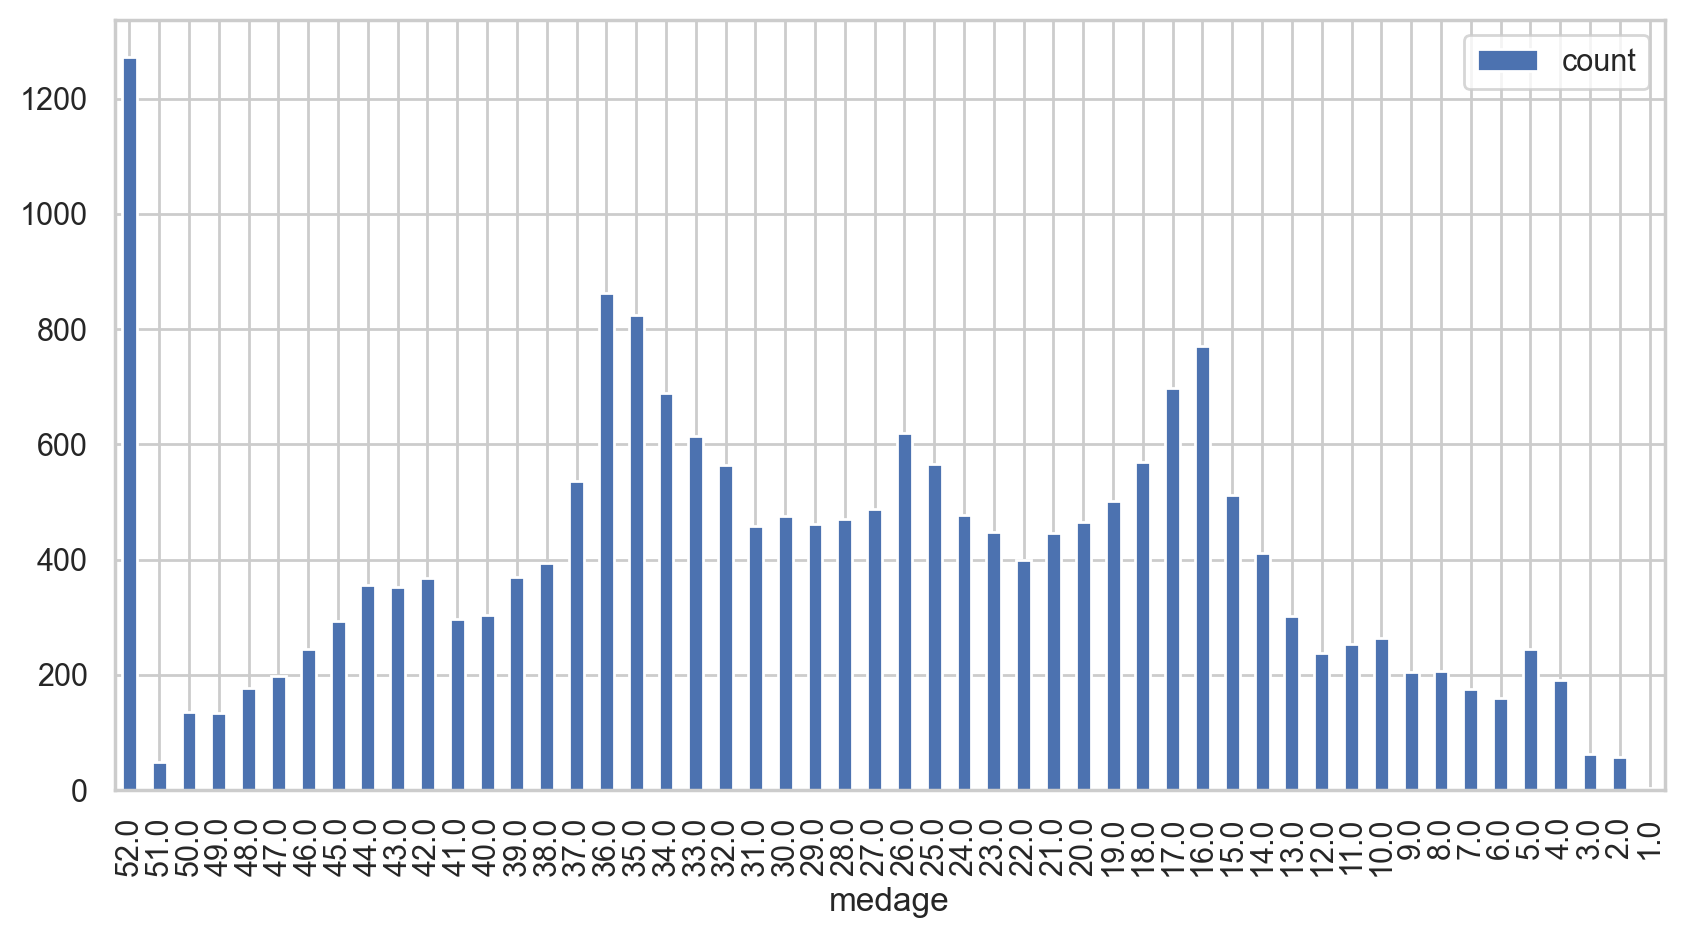

In [18]:
result_df.toPandas().plot.bar(x = 'medage', figsize = (10, 5)) ;

ส่วนใหญ่ประชากรที่อาศัยอยู่ที่นี่เป็นเยาวชนหรือผู้ที่เลือกที่จะอยู่ที่นี่ในช่วงปีชราหรือวัยผู้สูงอายุของตนเอง อย่างไรก็ตาม มีข้อมูลบางส่วนที่แสดงถึงอายุเฉลี่ยที่น้อยกว่า 10 ซึ่งดูเหมือนจะไม่เหมาะสมกับสถานการณ์

### 4.2 Summary Statistics

`Spark DataFrames` รวมถึงฟังก์ชั่นบางอย่างที่มีอยู่แบบสร้างให้เองสำหรับการประมวลผลทางสถิติ   
ฟังก์ชั่น `describe()` ดำเนินการคำนวณสถิติสรุปบนคอลัมน์ที่เป็นตัวเลขทั้งหมดและส่งคืนเป็น DataFrame

In [19]:
housing_df.describe(['medage']).show()

+-------+------------------+
|summary|            medage|
+-------+------------------+
|  count|             20640|
|   mean|28.639486434108527|
| stddev| 12.58555761211163|
|    min|               1.0|
|    max|              52.0|
+-------+------------------+



In [20]:
housing_df.describe().select('summary',
                              F.round('medage', 4).alias('medage'),
                              F.round('totrooms', 4).alias('totrooms'),
                              F.round('totbdrms', 4).alias('totbdrms'),
                              F.round('pop', 4).alias('pop'),
                              F.round('houshlds', 4).alias('houshlds'),
                              F.round('medinc', 4).alias('medinc'),
                              F.round('medhv', 4).alias('medhv')).show()

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



*สรุป*  
มองไปที่ค่า minimum and maximum ของทุกคุณสมบัติ (ที่เป็นตัวเลข) พบว่ามีคุณสมบัติหลายอย่างที่มีช่วงค่ากว้าง: เราจะต้องทำ `การปรับข้อมูลให้มีมาตรฐาน (normalize)`

**[Back to Table of Contents](#10)**

***

<a id="5"></a>
## 5. Data Preprocessing

ด้วยข้อมูลทั้งหมดที่เราได้รวบรวมจากการวิเคราะห์ข้อมูลแบบสำรวจเบื้องต้นนี้ เรามีข้อมูลเพียงพอที่จะทำการก่อนประมวลผลข้อมูลเพื่อนำมาใช้กับโมเดลได้

    1. เราไม่ควรกังวลเรื่องค่าที่หายไป ค่าศูนย์ทั้งหมดได้ถูกยกเว้นออกจากชุดข้อมูล
    2. เราควรมาตรฐานข้อมูลของเรา เนื่องจากเราเห็นว่าช่วงค่าขั้นต่ำและค่าสูงสุดมีความแตกต่างกันอย่างมาก
    3. อาจจะมีคุณสมบัติเพิ่มเติมบางอย่างที่เราสามารถเพิ่ม เช่น คุณสมบัติที่บันทึกจำนวนห้องนอนต่อห้องหรือห้องต่อครัวเรือน (the number of bedrooms per room or the rooms per household)
    4. ตัวแปรที่ขึ้นอยู่กับตัวแปรอื่นๆ (ตัวแปรตาม: medhv) ยังมีค่าที่สูงมากด้วย เพื่อให้ง่ายต่อการใช้งาน เราจะต้องปรับค่าเล็กน้อย

### 5.1 Preprocessing The Target Values

เริ่มต้นด้วย **`Median House Value`** ซึ่งเป็นตัวแปรตาม เพื่อให้ง่ายต่อการทำงานกับค่าเป้าหมาย เราจะแสดงผลค่ามูลค่าบ้านในหน่วยเป็นแสน เช่น 452600 ควรกลายเป็น 4.526

In [21]:
# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn('medhv', col('medhv')/100000)

In [22]:
# Show the first 5 lines of `df`
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 5 rows



**[Back to Table of Contents](#10)**

***

<a id="6"></a>
## 6. Feature Engineering

เมื่อเราได้ปรับค่าใน `medianHouseValue` แล้ว เราจะเพิ่มคอลัมน์ต่อไปนี้ในชุดข้อมูล:

**`1. Rooms per household`** ซึ่งหมายถึงจำนวนห้องในครัวเรือนต่อกลุ่มบล็อก  
**`2. Population per household`** ซึ่งให้เรามีความรู้เกี่ยวกับจำนวนคนที่อาศัยอยู่ในครัวเรือนต่อกลุ่มบล็อก  
**`3. Bedrooms per room`** ซึ่งจะให้เรารู้ว่ามีห้องนอนกี่ห้องต่อกลุ่มบล็อก  

เนื่องจากเรากำลังทำงานกับ DataFrame เราสามารถใช้ `select()` เพื่อเลือกคอลัมน์ที่เรากำลังทำงานด้วย คือ `totalRooms`, `households`, และ `population` นอกจากนี้ เราต้องระบุว่าเรากำลังทำงานกับคอลัมน์โดยการเพิ่มฟังก์ชัน `col()` เข้ามาในโค้ดของเรา มิฉะนั้น เราจะไม่สามารถทำการดำเนินการที่มีองค์ประกอบแบบอิลิเมนต์ได้ เช่นการหารทีละองค์ประกอบที่เราคาดหวังสำหรับตัวแปรเหล่านี้ได้

In [23]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [24]:
# Add the new columns to `df`
housing_df = (housing_df.withColumn('rmsperhh', F.round(col('totrooms')/col('houshlds'), 2))
                        .withColumn('popperhh', F.round(col('pop')/col('houshlds'), 2))
                        .withColumn('bdrmsperrm', F.round(col('totbdrms')/col('totrooms'), 2)))

In [25]:
# Inspect the result
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



*สรุป*  
เราสามารถเห็นได้ว่าสำหรับแถวแรกมีห้องประมาณ 6.98 ห้องต่อครัวเรือน ครัวเรือนในกลุ่มบล็อกประกอบด้วยประมาณ 2.56 คน และจำนวนห้องนอนน้อยมากเพียง 0.15

เนื่องจากเราไม่ต้องการเรียงลำดับค่าเป้าหมายของเราให้เป็นมาตรฐานเสมอ ดังนั้นเราต้องตรวจสอบให้แน่ใจว่าเราแยกข้อมูลเหล่านั้นออกจากชุดข้อมูลของเรา โปรดทราบว่านี่เป็นเวลาที่ต้องพิจารณาการตัดตัวแปรที่เราอาจไม่ต้องการพิจารณาในการวิเคราะห์ของเรา ในกรณีนี้ เราจะตัดตัวแปรออก เช่น ลองจิจูด (longitude) ละติจูด (latitude) อายุเฉลี่ยของบ้าน (housingMedianAge) และจำนวนห้องทั้งหมด (totalRooms) 

ในกรณีนี้ เราจะใช้ `select()` และระบุชื่อคอลัมน์ตามลำดับที่เหมาะสมมากขึ้น ในกรณีนี้ ตัวแปรเป้าหมาย `medianHouseValue` ถูกวางไว้ก่อนเพื่อให้ไม่ได้รับผลกระทบจากการปรับข้อมูลให้มีมาตรฐาน (normalize)



In [26]:
# Re-order and select columns
housing_df = housing_df.select('medhv', 
                               'totbdrms', 
                               'pop', 
                               'houshlds', 
                               'medinc', 
                               'rmsperhh', 
                               'popperhh', 
                               'bdrmsperrm')

In [27]:
housing_df.show(5)

+-----+--------+------+--------+------+--------+--------+----------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|
+-----+--------+------+--------+------+--------+--------+----------+
|4.526|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|
|3.585|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|
|3.521|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|      0.13|
|3.413|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|      0.18|
|3.422|   280.0| 565.0|   259.0|3.8462|    6.28|    2.18|      0.17|
+-----+--------+------+--------+------+--------+--------+----------+
only showing top 5 rows



### 6.1 Feature Extraction

ตอนนี้ที่เราได้เรียงลำดับข้อมูลแล้ว เราพร้อมที่จะทำการปรับข้อมูลให้เป็นมาตรฐานได้แล้ว เราจะเลือกคุณลักษณะที่ต้องการที่จะทำการปรับมาตรฐาน

In [28]:
featureCols = ['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

#### Use a VectorAssembler to put features into a feature vector column:

In [29]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols = featureCols, outputCol = 'features') 

In [30]:
assembled_df = assembler.transform(housing_df)

In [31]:
assembled_df.show(5, truncate = False)

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


คุณลักษณะทั้งหมดถูกแปลงเป็นเวกเตอร์หนาแน่น (Dense Vector) แล้ว

### 6.2 Standardization

ต่อไปเราสามารถปรับขนาดข้อมูลโดยใช้ `StandardScaler` ได้ สุดท้ายแล้ว คอลัมน์ input คือ features และคอลัมน์ output ที่จะเปลี่ยนขนาดที่จะถูกนำเข้าใน scaled_df จะถูกตั้งชื่อว่า "features_scaled"

In [32]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol = 'features', outputCol = 'features_scaled')

In [33]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [34]:
# Inspect the result
scaled_df.select('features', 'features_scaled').show(5, truncate = False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

**[Back to Table of Contents](#10)**

***

<a id="7"></a>
## 7. Building A Machine Learning Model With Spark ML

In [35]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed = rnd_seed)

In [36]:
train_data.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

In [37]:
print(f'Row of Train Data: {train_data.count()}')

Row of Train Data: 16499


In [38]:
print(f'Row of Test Data: {test_data.count()}')

Row of Test Data: 4141


In [39]:
# Initialize `lr`
lr = LinearRegression(featuresCol = 'features_scaled', 
                      labelCol = 'medhv', 
                      predictionCol = 'predmedhv', 
                      maxIter = 10, 
                      regParam = 0.3, 
                      elasticNetParam = 0.8, 
                      standardization = False)

In [40]:
# Fit the data to the model
linearModel = lr.fit(train_data)

**[Back to Table of Contents](#10)**

***

<a id="8"></a>
## 8. Evaluating the Model

### 8.1 Inspect the Model Co-efficients

In [41]:
# Coefficients for the model
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5262, 0.0, 0.0, 0.0])

In [42]:
featureCols

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

In [43]:
# Intercept for the model
linearModel.intercept

1.001383351659608

In [44]:
coeff_df = pd.DataFrame({'Feature' : ['Intercept'] + featureCols, 
                         'Co-efficients' : np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[['Feature', 'Co-efficients']]

In [45]:
coeff_df

,Feature,Co-efficients
0,Intercept,1.001383
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.526157
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


### 8.2 Generating Predictions

In [46]:
# Generate predictions
predictions = linearModel.transform(test_data)

In [47]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select('predmedhv', 'medhv')

In [48]:
predandlabels.show()

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
|1.1498290146733698|0.14999|
| 1.303758290180578|  0.225|
|1.7529725743151858|  0.225|
|1.6094289295308721|  0.269|
|1.5956645319495766|  0.344|
|1.2917940087238424|  0.367|
|1.8668547795751218|  0.375|
|1.3694233397856368|  0.394|
| 1.530553343912004|  0.398|
|1.5715143715849273|  0.409|
|1.3261913014043996|  0.417|
|1.2299232046905868|  0.425|
| 1.484164070093314|  0.425|
|1.3510338217435216|   0.43|
|1.2619110212709583|  0.436|
|1.3350814464678742|   0.44|
|1.4832778453641753|   0.44|
|1.4337313361080326|  0.444|
|1.3691187093204964|  0.445|
|1.4752185586821598|  0.446|
+------------------+-------+
only showing top 20 rows



### 8.3 Inspect the Metrics

In [49]:
# Get the RMSE
print(f'RMSE: {linearModel.summary.rootMeanSquaredError}')

RMSE: 0.881985204526886


In [50]:
# Get the MAE
print(f'MAE: {linearModel.summary.meanAbsoluteError}')

MAE: 0.678289531991799


In [51]:
# Get the R2
print(f'R2: {linearModel.summary.r2}')

R2: 0.4180854895364574


*สรุป*  

***RMSE***  

    - ค่า RMSE (Root Mean Square Error) ใช้วัดความคลาดเคลื่อนระหว่างสองชุดข้อมูล โดยเปรียบเทียบค่าคาดการณ์กับค่าสังเกต ค่า RMSE ที่น้อย แสดงถึงความใกล้เคียงของค่าคาดการณ์และค่าสังเกตมีความใกล้เคียงกัน
    

***R-Squared***

นิยามของค่า R-Squared คือ ค่าความผันแปรของตัวแปรตอบสนองที่สามารถอธิบายได้มีอยู่ในตัวแบบเชิงเส้นนี้ กี่เปอร์เซ็นต์ หรือ  

R-Squared = ความผันแปรที่สามารถอธิบายได้ / ความผันแปรทั้งหมด (Explained variation / Total Variation)

ค่า R-Squared จะมีค่าอยู่ระหว่าง  0%  - 100% (หรือ 0 ถึง 1 ในกรณีนี้)

    - 0% แสดงให้เห็นว่า ตัวแบบคณิตศาสาตร์ที่ได้มานั้นไม่สามารถอธิบายความผันแปรของค่าตัวแปรตอบสนอง ต่างที่กระจายรอบค่าเฉลี่ยได้เลย
    - 100% แสดงให้เห็นว่า ตัวแบบคณิตศาสาตร์ที่ได้มานั้นสามารถอธิบายความผันแปรของค่าตัวแปรตอบสนอง ต่างที่กระจายรอบค่าเฉลี่ยได้เป็นอย่างดี

โดยทั่วไปแล้ว ค่า R-Squared สูงๆ หมายความว่า ตัวแบบคณิตศาสตร์นั้นดี (เหมาะสมกับข้อมูล) แต่อย่างไรก็ตาม ยังมีเงื่อนไขบางอย่างที่ต้องมีพร้อมกับค่า R-Squared สูงๆนี้ด้วย

#### Using the RegressionEvaluator from pyspark.ml package:

In [52]:
evaluator = RegressionEvaluator(predictionCol = 'predmedhv', labelCol = 'medhv', metricName = 'rmse')
print(f'RMSE: {evaluator.evaluate(predandlabels)}')

RMSE: 0.8677342923034236


In [53]:
evaluator = RegressionEvaluator(predictionCol = 'predmedhv', labelCol = 'medhv', metricName = 'mae')
print(f'MAE: {evaluator.evaluate(predandlabels)}')

MAE: 0.673609774576463


In [54]:
evaluator = RegressionEvaluator(predictionCol = 'predmedhv', labelCol = 'medhv', metricName = 'r2')
print(f'R2: {evaluator.evaluate(predandlabels)}')

R2: 0.42517112885139363


In [55]:
spark.stop()

**[Back to Table of Contents](#10)**

***

<a id="9"></a>
## 9. Reference

kaggle & guideline  
- https://www.kaggle.com/code/fatmakursun/pyspark-ml-tutorial-for-beginners/notebook

- https://blog.datath.com/cheatsheet-pyspark/

- https://medium.com/super-ai-engineer/%E0%B9%80%E0%B8%97%E0%B8%84%E0%B8%99%E0%B8%B4%E0%B8%84%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B9%83%E0%B8%8A%E0%B9%89-pyspark-%E0%B8%81%E0%B8%B1%E0%B8%9A-big-data-4e2c17d081b4

R2
- https://www.tpa.or.th/writer/read_this_book_topic.php?bookID=3086&read=true

**[Back to Table of Contents](#10)**

***